In [109]:
import os

import pandas as pd
from tifffile import TiffFile
from ome_types import from_tiff, from_xml
# import seaborn as sns 
import numpy as np
import PIL
import matplotlib.pyplot as plt

In [110]:
from deepcell.datasets import multiplex_tissue
from deepcell.utils.plot_utils import create_rgb_image
from deepcell.applications import Mesmer

In [111]:
import tensorflow as tf
tf.__version__

'2.5.3'

In [112]:
def get_channels(fp):   
    tif = TiffFile(fp)
    ome = from_xml(tif.ome_metadata)
    im = ome.images[0]
    return [channel.name for channel in im.pixels.channels]

def extract_htan_ome_tiff(fp):   
    tif = TiffFile(fp)
    ome = from_xml(tif.ome_metadata)
    im = ome.images[0]
    d = {}
    for c, p in zip(im.pixels.channels, tif.pages):
        img = p.asarray()
        d[c.name] = img
    return d

def get_percentile_cut(img, pcts=[.99]):
    flat = np.sort(img.flatten())
    return [flat[int(p * flat.shape[0])] for p in pcts] 

def merge_channels(channel_to_img, channels):
    img = None
    for c in channels:
        X = channel_to_img[c]
        X = np.expand_dims(X, 0)
        if img is None:
            img = X
        else:
            img = np.concatenate((img, X), axis=0)
    img = np.mean(img, axis=0)
    return img

In [113]:
ome_fp = '/data/multiplex/codex_inhouse/codex/HT206B1-H1/ome_tiff/HT206B1-H1.ome.tiff'
channel_to_img = extract_htan_ome_tiff(ome_fp)

In [6]:
import tifffile
tifffile.imread('/data/HT323B1/stiched/reg001_cyc001_ch001_DAPI-01.tif')

array([[  3, 101,   3, ...,  16,  33,  26],
       [  3,  20,   3, ...,   5,  30,  40],
       [  3,   3,  13, ...,  46, 178, 257],
       ...,
       [ 29, 255,  88, ...,  91, 172, 121],
       [127,  36,  40, ...,  75,  15,  99],
       [ 79,  41,  16, ...,  18, 141, 359]], dtype=uint16)

In [7]:
channel_to_img = {
    'DAPI': tifffile.imread('/data/HT323B1/stiched/reg001_cyc001_ch001_DAPI-01.tif'),
    'E-cadherin': tifffile.imread('/data/HT323B1/stiched/reg001_cyc002_ch003_E-cadherin.tif'),
    'Pan-CK': tifffile.imread('/data/HT323B1/stiched/reg001_cyc004_ch002_Pan-CK.tif'),
    'CD45RO': tifffile.imread('/data/HT323B1/stiched/reg001_cyc006_ch003_CD45RO.tif'),
    'Vimentin': tifffile.imread('/data/HT323B1/stiched/reg001_cyc006_ch002_Vimentin.tif'),
    'CD3': tifffile.imread('/data/HT323B1/stiched/reg001_cyc005_ch004_CD3e.tif'),
}

In [114]:
channel_to_img.keys()

dict_keys(['DAPI', 'CD31', 'E-cadherin', 'Pan-CK', 'CD3', 'CD45RO', 'Vimentin'])

In [115]:
membrane = merge_channels(channel_to_img, ['E-cadherin', 'Pan-CK', 'CD45RO', 'Vimentin', 'CD3', 'CD31'])
membrane.shape

(15120, 13440)

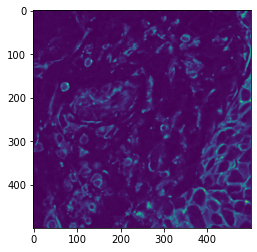

In [116]:
r1, r2, c1, c2 = 11000, 11500, 11000, 11500
plt.imshow(membrane[r1:r2, c1:c2])

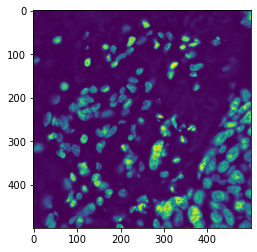

In [117]:
plt.imshow(channel_to_img['DAPI'][r1:r2, c1:c2])

In [118]:
channel_to_img['nuclear'] = channel_to_img['DAPI']
channel_to_img['membrane'] = membrane

In [119]:
# def get_percentile_cut(img, pcts=[.99]):
#     flat = np.sort(img.flatten())
#     return [flat[int(p * flat.shape[0])] for p in pcts] 

# for c, img in channel_to_img.items():
#     print(c, img.shape, np.max(img), get_percentile_cut(img, pcts=[.9, .95, .99, .995]))

In [120]:
for c, img in channel_to_img.items():
    if c not in ['nuclear', 'membrane']:
        channel_to_img[c] = None
        del img
    

In [121]:
input_img = np.concatenate((np.expand_dims(channel_to_img['nuclear'], axis=-1),
                            np.expand_dims(channel_to_img['membrane'], axis=-1)), axis=-1)
input_img = np.expand_dims(input_img, axis=0)
input_img.shape

(1, 15120, 13440, 2)

In [126]:
def get_batched_img(input_img, window=(5000, 5000)):
    rc_to_img = {}
    n_rows, n_cols = (input_img.shape[1] // window[0]) + 1, (input_img.shape[2] // window[1]) + 1
    for r in range(n_rows):
        for c in range(n_cols):
            r1, r2 = r * window[0], (r + 1) * window[0]
            c1, c2 = c * window[1], (c + 1) * window[1]
            rc_to_img[(r, c)] = input_img[:, r1:r2, c1:c2, :]

    return rc_to_img
    

In [129]:
rc_to_img = get_batched_img(input_img)
for k, v in rc_to_img.items():
    print(k, v.shape)


(0, 0) (1, 10000, 10000, 2)
(0, 1) (1, 10000, 3440, 2)
(1, 0) (1, 5120, 10000, 2)
(1, 1) (1, 5120, 3440, 2)


In [130]:
app = Mesmer()

In [131]:
import tensorflow
# tensorflow.test.gpu_device_name()

In [133]:
%%time
rc_to_segmented = {}
for k, v in rc_to_img.items():
    print(k)
    segmentation_predictions = app.predict(input_img, image_mpp=1.)
    rc_to_segmented[k] = segmentation_predictions
for k, v in rc_to_segmented.items():
    print(k, v.shape)

(0, 0)


/data/estorrs/miniconda3/envs/segmentation/lib/python3.7/site-packages/deepcell_toolbox/deep_watershed.py:108: UserWarning: h_maxima peak finding algorithm was selected, but the provided image is larger than 5k x 5k pixels.This will lead to slow prediction performance.
  warnings.warn('h_maxima peak finding algorithm was selected, '


(0, 1)
(1, 0)
(1, 1)
(0, 0) (1, 15120, 13440, 1)
(0, 1) (1, 15120, 13440, 1)
(1, 0) (1, 15120, 13440, 1)
(1, 1) (1, 15120, 13440, 1)
CPU times: user 1d 20h 48min 27s, sys: 1d 4h 35min 47s, total: 3d 1h 24min 15s
Wall time: 4h 34min 39s


In [107]:
%%time
segmentation_predictions = app.predict(input_img, image_mpp=1.)

/data/estorrs/miniconda3/envs/segmentation/lib/python3.7/site-packages/deepcell_toolbox/deep_watershed.py:108: UserWarning: h_maxima peak finding algorithm was selected, but the provided image is larger than 5k x 5k pixels.This will lead to slow prediction performance.
  warnings.warn('h_maxima peak finding algorithm was selected, '


CPU times: user 5h 25min 33s, sys: 3h 32min 8s, total: 8h 57min 42s
Wall time: 29min 56s


In [20]:
%%time
segmentation_predictions = app.predict(input_img, image_mpp=1.)

/usr/local/lib/python3.6/dist-packages/deepcell_toolbox/deep_watershed.py:108: UserWarning: h_maxima peak finding algorithm was selected, but the provided image is larger than 5k x 5k pixels.This will lead to slow prediction performance.
  warnings.warn('h_maxima peak finding algorithm was selected, '


CPU times: user 11min 6s, sys: 2min 9s, total: 13min 15s
Wall time: 12min 54s


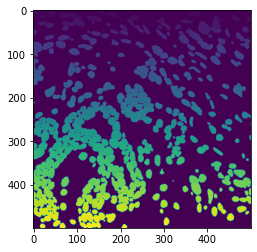

In [81]:
plt.imshow(segmentation_predictions[0, :, :, 0])

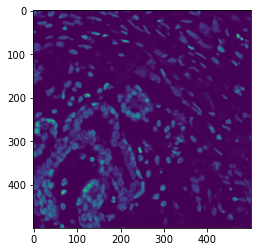

In [82]:
r1, r2, c1, c2 = 0, 3000, 0, 1500
plt.imshow(input_img[0, r1:r2, c1:c2, 0])  

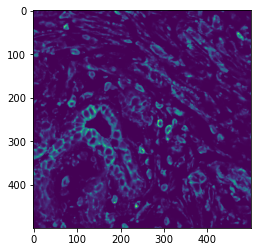

In [83]:
plt.imshow(input_img[0, r1:r2, c1:c2, 1])

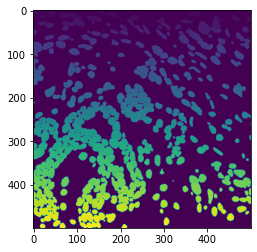

In [84]:
plt.imshow(segmentation_predictions[0, r1:r2, c1:c2, 0])

In [85]:
from deepcell.utils.plot_utils import create_rgb_image

# create rgb overlay of image data for visualization
rgb_images = create_rgb_image(input_img[:, r1:r2, c1:c2, :], channel_colors=['green', 'blue'])


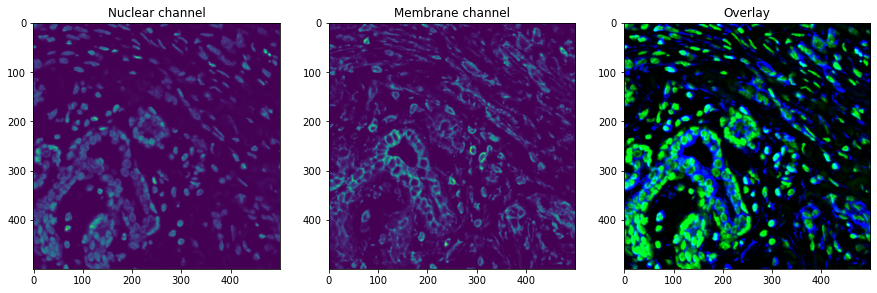

In [86]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
ax[0].imshow(input_img[0, r1:r2, c1:c2, 0])
ax[1].imshow(input_img[0, r1:r2, c1:c2, 1])
ax[2].imshow(rgb_images[0, ...])

ax[0].set_title('Nuclear channel')
ax[1].set_title('Membrane channel')
ax[2].set_title('Overlay')

plt.show()

In [87]:
from deepcell.utils.plot_utils import make_outline_overlay

overlay_data = make_outline_overlay(rgb_data=rgb_images, predictions=segmentation_predictions[:, r1:r2, c1:c2, :])

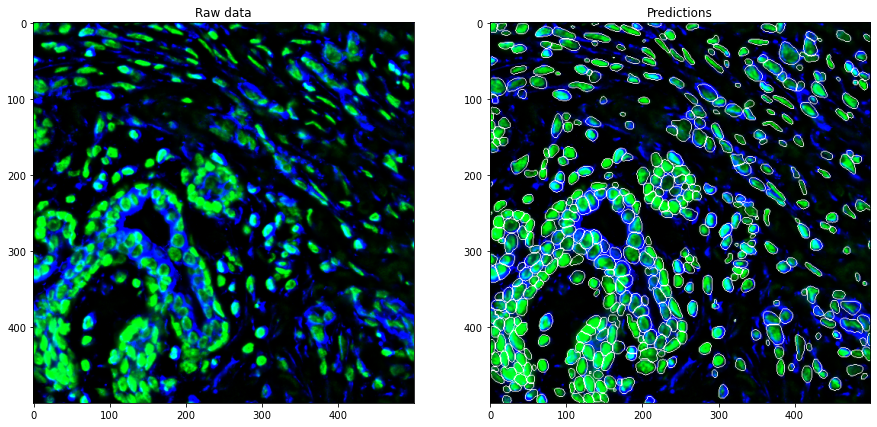

In [88]:
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(rgb_images[0, ...])
ax[1].imshow(overlay_data[0, ...])
ax[0].set_title('Raw data')
ax[1].set_title('Predictions')
plt.show()

###### tutorial from https://github.com/vanvalenlab/deepcell-tf/blob/master/notebooks/applications/Mesmer-Application.ipynb

In [19]:
from deepcell.datasets import multiplex_tissue
((X_train, y_train),(X_test, y_test)) = multiplex_tissue.load_data()

In [4]:
X_train.shape, y_train.shape

((16, 512, 512, 2), (16, 512, 512, 1))

In [5]:
X_test.shape, y_test.shape

((4, 512, 512, 2), (4, 512, 512, 1))

In [20]:
np.max(X_train)

65514.0

In [6]:
from deepcell.utils.plot_utils import create_rgb_image

# create rgb overlay of image data for visualization
rgb_images = create_rgb_image(X_train, channel_colors=['green', 'blue'])

# select index for displaying
idx = 3

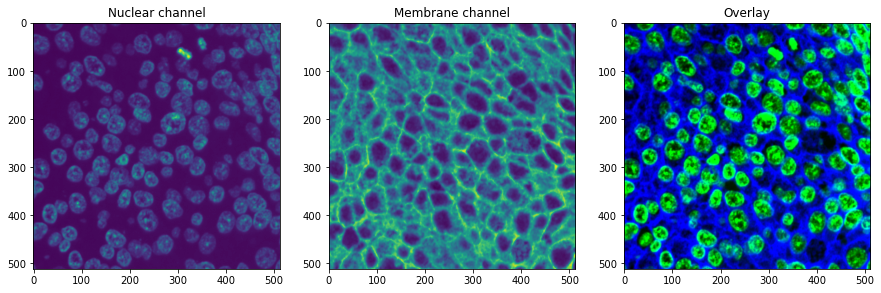

In [7]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
ax[0].imshow(X_train[idx, ..., 0])
ax[1].imshow(X_train[idx, ..., 1])
ax[2].imshow(rgb_images[idx, ...])

ax[0].set_title('Nuclear channel')
ax[1].set_title('Membrane channel')
ax[2].set_title('Overlay')

plt.show()

In [8]:
from deepcell.applications import Mesmer
app = Mesmer()

A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of e7360e8e87c3ab71ded00a577a61c689 so we will re-download the data.
96894976/96894291 [==============================] - 2s 0us/step


2022-02-09 10:39:20.355834: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-02-09 10:39:20.371968: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:1a:00.0 name: TITAN RTX computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-02-09 10:39:20.373279: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:3d:00.0 name: TITAN RTX computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-02-09 10:39:20.374513: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 2 with properties: 
pciBusID: 0000:89:00.0 name: TITAN RTX computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-02-09 10:39:20.375814: I tens

In [9]:
print('Training Resolution:', app.model_mpp, 'microns per pixel')

Training Resolution: 0.5 microns per pixel


In [10]:
segmentation_predictions = app.predict(X_train, image_mpp=0.5)

2022-02-09 10:39:55.758529: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-09 10:39:55.779171: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2300000000 Hz


In [11]:
# create overlay of predictions
from deepcell.utils.plot_utils import make_outline_overlay
overlay_data = make_outline_overlay(rgb_data=rgb_images, predictions=segmentation_predictions)

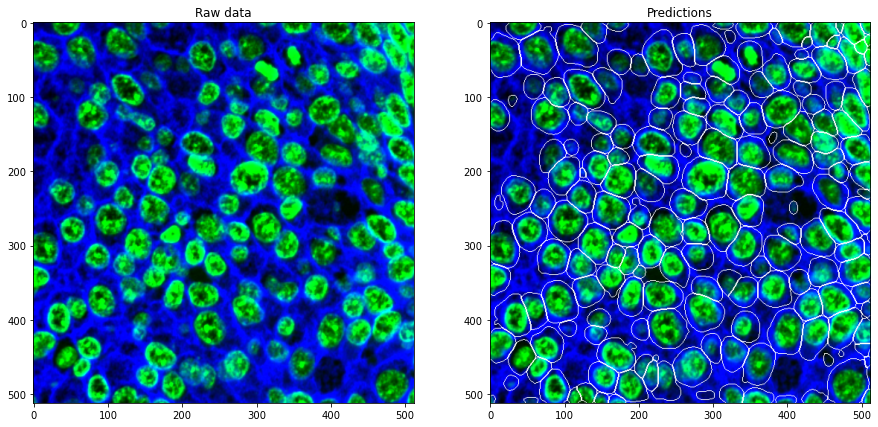

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(rgb_images[idx, ...])
ax[1].imshow(overlay_data[idx, ...])
ax[0].set_title('Raw data')
ax[1].set_title('Predictions')
plt.show()

In [14]:
segmentation_predictions.shape

(16, 512, 512, 1)